# Analyse exploratoire et modèle prédictif - Etude de cas du Titanic

## Etape 1 - Business Understanding

“Le transatlantique Titanic, le plus grand paquebot du monde, appartenant à la compagnie anglaise The White Star Line, a heurté la nuit dernière contre un iceberg, près des bancs de Terre-Neuve, et a coulé. Fort heureusement, les secours ont été prompts, et les passagers, au nombre de 2700, y compris l'équipage, ont pu être tous sauvés.”
C’est ce que nous pouvions lire le 16 avril 1912 dans l’Echo de Paris, mais aurions-nous pu prédire qui allait survivre ? C’est ce à quoi nous allons tenter de répondre à travers cette analyse. Pour se faire nous allons comparer des modèles de machine learning au cours d'un exercice de classification binaire.

Pour cela nous allons : 
- Réaliser une analyse de la qualité des données et faire le lien entre les données et leur signification pour notre étude
- Analyser et identifier les facteurs favorisant la survie 
- Mettre en place un modèle de prédiction permettant de déterminer qui a survécu au naufrage sur nos données de test 

Voici un rapide aperçu du sommaire : 
- Etape 1 - Business Understanding 
    - Import des librairies 
    - Lecture des données d'entrainement et de test
- Etape 2 - Data Understanding
    - Description du dataset train
    - Description du dataset test
    - Identification des outliners et traitement des valeurs manquantes
    - Identification des outliers pour les variables numériques
    - Identification des doublons
    - Traitement des valeurs manquantes (pour l'âge, le ticket, la cabine, le port d'embarquement)
    - Réponses à nos interrogations sur les facteurs favorisant la survie
- Etape 3 - Data preparation 
    - Feature engineering 
    - Préparation du modèle de machine learning
- Etape 4 - Modeling
- Etape 5 - Evaluation & Optimisation
    - Sélection du modèle le plus performant 
    - Poids des features dans le modèle
    - Identification des meilleurs hyperparamètres 
    - Score F1 de la Random Forest avec les hyperparamètres optimisés
    - Matrice de confusion
    - Courbe ROC
Le sommaire est très riche je vous l'accorde cependant j'ai tenté d'être aussi exhaustif que possible dans le choix de mes analyses. 

Les analyses sont toutes basées sur le dataset du Titanic de Kaggle disponible à l'adresse suivante : https://www.kaggle.com/competitions/titanic/data

/!\ Ce Jupyter Notebook est le fruit de ma propre réflexion et de mes recherches. Il n'existe aucun code sur stack overflow, github ou kaggle qui obtient les mêmes résultats sur leurs modèles !

### Import des librairies 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xgboost
%matplotlib inline

from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc, make_scorer, confusion_matrix, f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer

# Importation des classifieurs Naive Bayes, régression logistique, Bagging, RandomForest, AdaBoost, GradientBoost, arbre de décision, SVM et XGBoost
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# On va définir ici le style de tracé (graphique)
plt.style.use('seaborn-notebook')
from matplotlib.ticker import StrMethodFormatter

sns.set(style='white', context='notebook', palette='deep')

### Lecture des données d'entraînement et de test

In [2]:
# Ici nous allons chercher à nous connecter à nos données en indiquant notre répertoire
train = pd.read_csv("C:/Users/kcho/Desktop/Titanic/train.csv")
test = pd.read_csv("C:/Users/kcho/Desktop/Titanic/test.csv")
IDtest = test["PassengerId"]

Pour réaliser cette étude de cas nous allons utiliser la méthode CRISP-DM c'est à dire : 
1) Business Understanding
2) Data Understanding 
3) Data Preparation
4) Modeling 
5) Evaluation
6) Deployment 

## Etape 2 - Data Understanding

### Description du dataset 'train'

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Cet aperçu nous permet de mieux comprendre les différentes composantes de notre dataset et d’amener nos premières pistes de réflexions. Voici un résumé pour chacune des colonnes : 

- PassengerId : Numéro d'identification unique d'un passager
- Survival : le passager a survécu ou non ; 1 s'il a survécu et 0 s'il n'a pas survécu.
- Pclass : Classe du ticket (1= première classe, 2= seconde classe,3= troisième classe). Peut être considéré comme un élément permettant d’évaluer le statut socio-économique de l’individu.
- Sex : sexe
- Age : âge en années
- Sibsp : Nombre de frères et sœurs / conjoints à bord du Titanic
- Parch : Nombre de parents / enfants à bord du Titanic
- Ticket : Numéro du ticket
- Fare : Tarif passager
- Cabin : Numéro de la cabine
- Embarked : Port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton)

On peut les regrouper en fonction de la typologie de variables auxquelles elles appartiennent : 

- Variables catégorielles :

    - Nominales (variables ayant deux catégories ou plus, mais qui n'ont pas d'ordre intrinsèque)
        Cabin
        Embarked (Port d'embarquement : C (Cherbourg),Q (Queenstown), S (Southampton)

    - Dichotomiques (variable nominale avec seulement deux catégories)
        Sex (Homme/Femme)

- Ordinales (variables ayant deux catégories ou plus, tout comme les variables nominales. Seules les catégories peuvent également être ordonnées ou classées.)
    - Pclass (statut socio-économique : 1 (Première classe, classe premium), 2 (Seconde classe), 3 (Troisème classe)
- Variables numériques :
    - Discrètes
        PassengerID(identifiant unique pour chaque passager)
        SibSp
        Parch
        Survived (notre résultat ou variable dépendante : 0 ou 1)

- Continues
    Age
    Fare

- Variables textuelles :
    Ticket (numéro de billet pour le passager)
    Name (nom du passager)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.shape

(891, 12)

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Description du dataset 'test'

In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
test.shape

(418, 11)

In [10]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Les tableaux ci-dessus nous permettent de constater certaines choses :
- Nous avons quelques variables catégorielles qui doivent être converties en données numériques afin que les algorithmes d'apprentissage automatique puissent les traiter.
- Les features ont des échelles très différentes et nous devrons les convertir à peu près à la même échelle.
- Certaines features contiennent des valeurs manquantes (NaN = Not a Number), que nous devons traiter.

## Identification des outliners et traitement des valeurs manquantes

 Nous allons donc tenter d'approfondir nos analyses concernant les données à notre disposition pour tenter d'identifier : 
 - Les valeurs aberrantes/outliers
 - Les doublons
 - Les valeurs manquantes
 
Une fois cela fait il sera possible de déterminer comment les traiter.

### Les valeurs manquantes

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
********************
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64

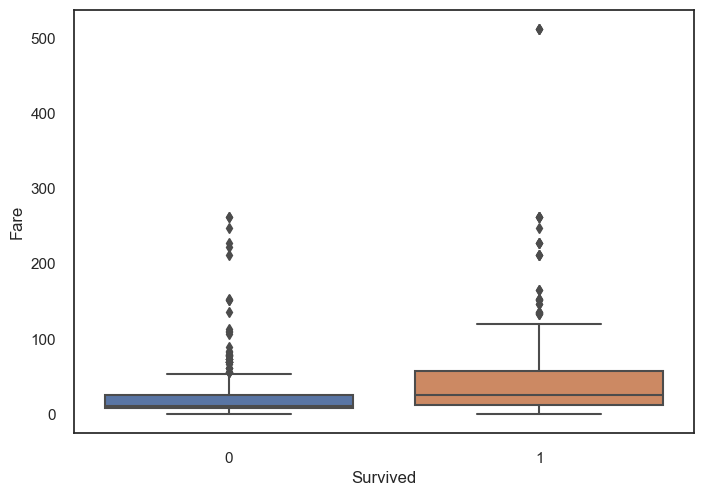

In [11]:
print (train.isnull().sum())
print (''.center(20, "*"))
print (test.isnull().sum())
sns.boxplot(x='Survived',y='Fare',data=train)
missing_values=train.isnull().sum() 
missing_values[missing_values>0]/len(train)*100

Ici on confirme et on identifie le nombre de valeurs manquantes pour les colonnes 'Age', 'Cabin' et 'Embarked’. Pour le dataset de train on constate 19,87% de valeurs manquantes pour l'âge, 77,10% pour le numéro de la Cabine et 0,2% de valeurs manquantes pour le point d'embarquement.

Les données manquantes dans l'ensemble de données d'entraînement peuvent réduire l'ajustement d'un modèle ou conduire à un modèle biaisé car nous n'avons pas correctement analysé le comportement et la relation avec d'autres variables. Cela peut conduire à des prédictions ou classifications erronées. Pour éviter cette problématique il est nécessaire de traiter ces valeurs manquantes en prennant en compte le contexte.

### Identification des outliers pour les variables numériques

J'ai voulu utiliser la méthode de Tukey pour identifier des outliers. Cependant la méthode de Tukey est opérationnelle lorsque nous sommes en proie à une distribution qui n'est pas normale. Nous allons donc commencer par afficher la distribution pour les variables numériques "Age", "SibSp", "Parch", et "Fare" afin de vérifier qu'elles ne répondent pas à une distribution normale.

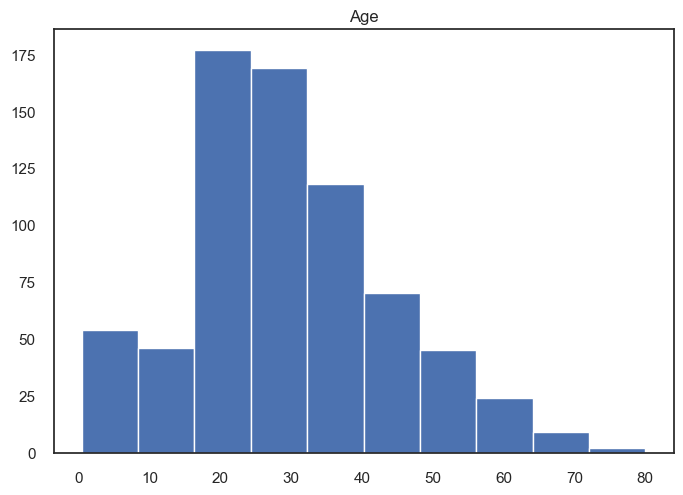

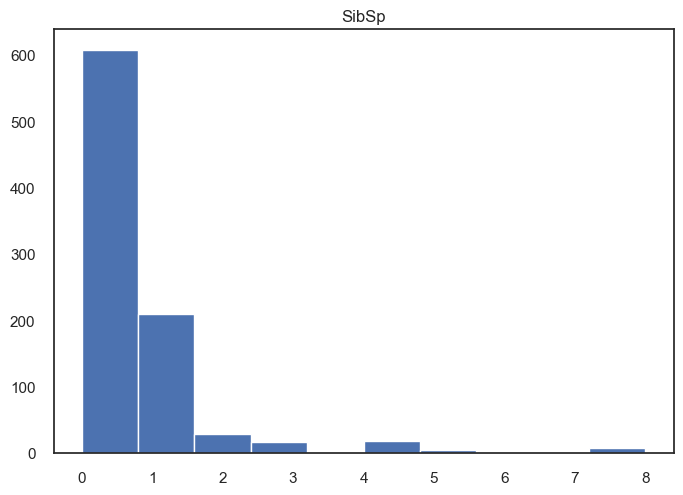

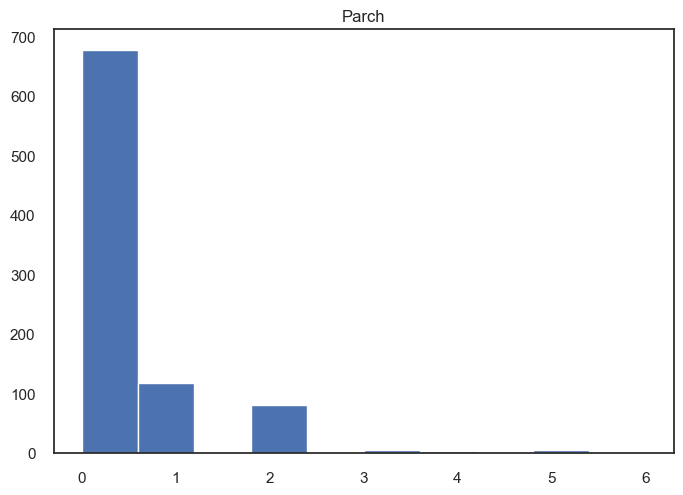

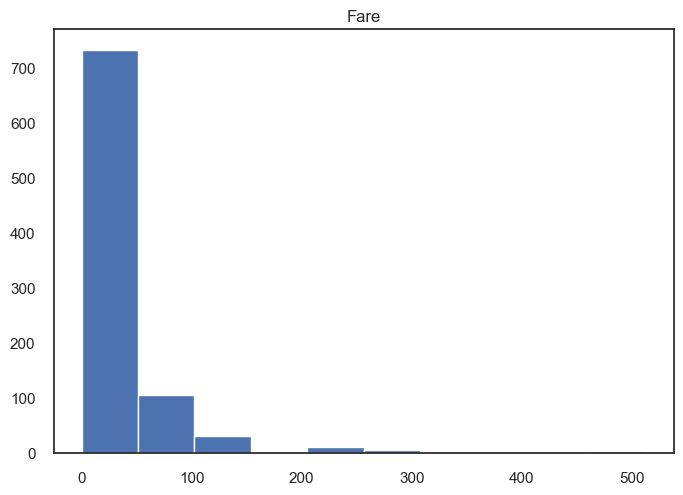

In [12]:
import matplotlib.pyplot as plt

for col in ["Age", "SibSp", "Parch", "Fare"]:
    plt.hist(train[col])
    plt.title(col)
    plt.show()


Afficher les histogrammes pour les variables numériques peut nous permettre de déterminer la direction dans laquelle ces variables sont distribuées, les valeurs aberrantes apparaîtront en dehors de la distribution globale des données. Si l'histogramme est asymétrique à droite ou à gauche, cela indique la présence de valeurs extrêmes ou de valeurs aberrantes. Ici nous pouvons donc déduire que certaines valeurs sont aberrantes (excepté pour l'age). L'âge n'est pas un problème car même avec une valeur min à 0,17 on peut très bien en déduire qu'il s'agit d'un bébé. Pour traiter les valeurs aberrantes on peut réaliser la méthode de Tukey cependant il faut vérifier que la distribution n'est pas normale c'est le but de l'étape suivante.

In [13]:
from scipy.stats import shapiro
import pandas as pd

# spécifier les colonnes à tester
cols_to_test = ["Survived", "PassengerId", "Pclass", "Age", "SibSp", "Parch", "Fare"]

# effectuer le test de Shapiro-Wilk sur chaque colonne
for col in cols_to_test:
    # extraire la colonne du dataframe
    data = train[col]

    # effectuer le test de Shapiro-Wilk sur la colonne
    stat, p = shapiro(data)

    # afficher le résultat du test
    print("Colonne : ", col)
    print("Statistiques du test de Shapiro-Wilk : ", stat)
    print("p-value : ", p)

    # interpréter le résultat du test
    alpha = 0.05
    if p > alpha:
        print("La distribution des données est normale (on ne peut pas rejeter H0)")
    else:
        print("La distribution des données n'est pas normale (on rejette H0)")


Colonne :  Survived
Statistiques du test de Shapiro-Wilk :  0.616659939289093
p-value :  1.7945308393836472e-40
La distribution des données n'est pas normale (on rejette H0)
Colonne :  PassengerId
Statistiques du test de Shapiro-Wilk :  0.9547972679138184
p-value :  6.309874531781976e-16
La distribution des données n'est pas normale (on rejette H0)
Colonne :  Pclass
Statistiques du test de Shapiro-Wilk :  0.718337893486023
p-value :  3.3958319924210316e-36
La distribution des données n'est pas normale (on rejette H0)
Colonne :  Age
Statistiques du test de Shapiro-Wilk :  nan
p-value :  1.0
La distribution des données est normale (on ne peut pas rejeter H0)
Colonne :  SibSp
Statistiques du test de Shapiro-Wilk :  0.5129655003547668
p-value :  5.74532370373175e-44
La distribution des données n'est pas normale (on rejette H0)
Colonne :  Parch
Statistiques du test de Shapiro-Wilk :  0.5328145027160645
p-value :  2.382207389352189e-43
La distribution des données n'est pas normale (on rejett

On constate donc que les différentes distributions des variables que nous avions identifiés ne sont pas normales. Nous pouvons donc utiliser la méthode de Tukey pour identifier les outliers.

In [14]:
# Détection des outliers

def detect_outliers(df,n,features):
    outlier_indices = []
    
    # Iterer sur chacune des colonnes du dataset
    for col in features:
        # Premier quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # Troisème quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Intervalle interquartile (le fameux IQR)
        IQR = Q3 - Q1
        
        # Niveau de la valeur aberrante que je fixe selon Turkey
        outlier_step = 1.5 * IQR
        
        # Déterminer une liste d'indices de valeurs aberrantes pour col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # Ajouter les indices de valeurs aberrantes trouvés pour col à la liste des indices de valeurs aberrantes
        outlier_indices.extend(outlier_list_col)
        
    # Sélectionner les observations contenant plus de 2 valeurs aberrantes
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# Détection des outliers des colonnes Age, SibSp , Parch and Fare : uniquement pour les valeurs numériques
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [15]:
train.loc[Outliers_to_drop] # On va afficher les outliers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Après quelques recherches sur internet concernant les informations sur le prix des billets que l'on aurait pu croire comme aberrantes avec une valeur de 512 (valeur max) sont finalement plausibles car certains voyageurs prennaient des appartements en plus etc... Nous détectons tout de même 10 valeurs aberrantes. Les 28, 89 et 342 passagers ont un 'Fare' élevé par rapport aux quartiles. Les 7 autres ont des valeurs très élevées de SibSP. Nous pouvons donc supprimer ces outliers, c'est le rôle de la ligne suivante.

In [16]:
# Suppression des outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### Identification des doublons

Une fois les outliers identifiés nous pouvons passer aux doublons. La ligne de code ci-dessous va nous permettre de compter les enregistrements en double.

In [17]:
# Trouver le nombre d'enregistrements en doublon
print('train - Nombre denregistrements en double:', train.duplicated().sum())
print('test - Nombre denregistrements en double:', test.duplicated().sum())

train - Nombre denregistrements en double: 0
test - Nombre denregistrements en double: 0


Dans notre cas on constate l'absence de doublons ce qui est plutôt positif pour nous car aucun retraitement ne sera à effectuer.

### Traitement des valeurs manquantes 

Une des étapes les plus délicates pour permettre à notre modèle d'avoir une bonne fiabilité ainsi que pour mener une analyse exploratoire digne de ce nom correspond au traitement des valeurs manquantes. Un mauvais traitement dans les valeurs manquantes (sans prise en compte du contexte) amènera à des données biaisées et à un manque de fiabilité de notre modèle. Nous allons faire en sorte de prendre en maximum le contexte des données pour déterminer comment traiter ces données manquantes.

#### Traitement des valeurs manquantes pour l'Age 

Nous avons dans les premières lignes de l'exploration de notre jeu de données constatés que l'age possèdaient de nombreuses lignes avec des valeurs manquantes. Il existe plusieurs manières de traiter ces lignes vides, la plus courante étant de calculer la moyenne d'âge et de l'imputer aux lignes manquantes. Cependant, on constate ici une diversité dans les profils de notre base de données. Si bien que j'ai décidé d'utiliser le titre présent dans le nom pour déterminer l'age de la ligne. Je m'explique, au lieu de calculer la moyenne sur toute la base de données je vais calculer la moyenne des âges des personnes possédants le même titre que la personne dont l'age est manquant. Ainsi nous gagnons en fiabilité, il est rare d'avoir un titre de 'Capt' lorsque l'on a 4 ans. Je suis donc parti du principe qu'il était de même pour les autres titres.

In [18]:
# Comme le test n'a qu'une seule valeur manquante, remplissons-la avec la moyenne.
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

# Concatenation des données d'entrainement et de test pour le traitement
data_df = pd.concat([train, test], ignore_index=True)

# Extraction des titres à partir des noms des passagers
data_df['Title'] = data_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=True)

# Remplacement des titres rares par les plus courants
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
           'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)

# Affichage des différents titres et leur nombre d'occurrences
print(data_df['Title'].value_counts())

# Imputation de l'âge manquant en utilisant la moyenne de l'âge par titre
titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Rev', 'Dr']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].mean()[title]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute

# Séparation des données d'entrainement et de test mises à jour
train = data_df.iloc[:len(train)]
test = data_df.iloc[len(train):]

# Vérification du nombre de valeurs nulles dans les données d'entrainement et de test
print(train.isnull().sum())
print(test.isnull().sum())


Mr        763
Miss      260
Mrs       200
Master     60
Rev         8
Dr          8
Name: Title, dtype: int64
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
Title            0
dtype: int64
PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Title            0
dtype: int64


Nous voilà avec un traitement des données manquantes pour l'âge : 

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


#### Traitement des valeurs manquantes pour le numéro de Cabine et suppresion de la colonne 'Ticket'

Au vue du nombre de données manquantes qui correspondent à 77% des données totales il est préférable de supprimer cette colonne. De plus, le numéro de cabine est difficilement exploitable en l'état car a une partie numérique et alphabétique. Par la même occasion nous allons supprimer la colonne 'Ticket' qui n'a aucune valeur dans notre analyse

In [20]:
print("Avant", train.shape, test.shape)

train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)

("Après", train.shape, test.shape)

Avant (881, 13) (418, 13)


('Après', (881, 11), (418, 11))

#### Traitement du sexe en changeant la catégorie

Afin de faciliter l'exploitation de nos données concernant le sexe ainsi que le traitement de notre modèle il est préférable de modifier le type de cette variable. De base, nous avions des chaines de caractère. Nous allons donc attribuer une valeur à chacun des 2 sexes (0 pour l'homme, 1 pour la femme).

In [21]:
# Mapper chaque valeur de la variable "Sexe" à une valeur numérique
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,Mr


#### Traitement des valeurs du port d'embarquement 

Pour traiter le faible nombre de valeurs manquantes pour le port d'embarquement j'ai décidé de remplacer les valeurs manquantes par la valeur la plus récurrente. La première ligne va nous permettre de déterminer la valeur la plus récurrente et la deuxième ligne complétera les valeurs manquantes du port d'embarquement en attribuant cette valeur.

In [22]:
freq_port = train.Embarked.dropna().mode()[0]
freq_port

'S'

In [23]:
for dataset in [train, test]:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.341195


### Analyse des résultats et interprétation 

Cette partie va nous permettre d'identifier des liens entre les variables et notre chance de survie. J'ai commencé par faire une heatmap permettant d'identifier les facteurs corrélés à notre survie. Cette heatmap servira de base à nos hypothèses et de pistes à explorer.

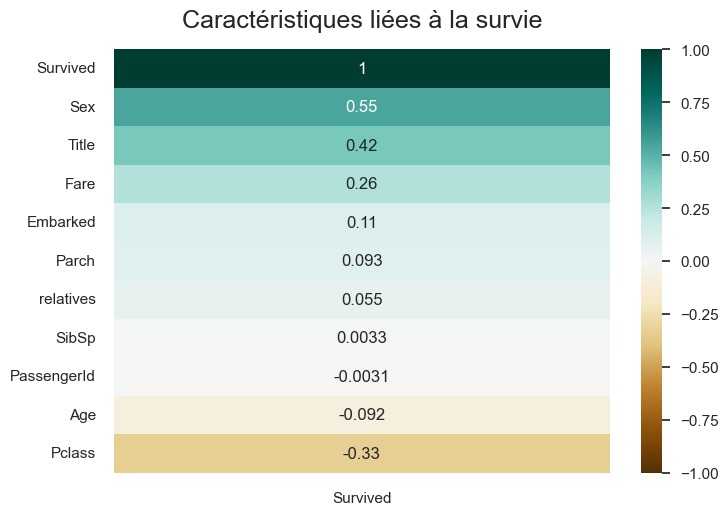

In [85]:
heatmap = sns.heatmap(train.corr()[['Survived']].sort_values(by='Survived', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Caractéristiques liées à la survie', fontdict={'fontsize':18}, pad=16);

##### Q1 : Combien de personnes ont embarqué depuis différents ports ? Y a-t-il une corrélation entre le port d'embarquement et la survie ?

In [25]:
train['Embarked'].value_counts()/len(train)

S    0.721907
C    0.190692
Q    0.087401
Name: Embarked, dtype: float64

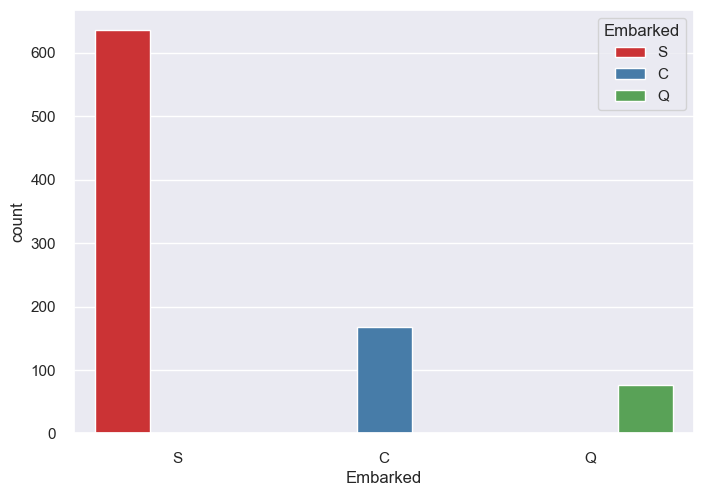

In [26]:
sns.set(style="darkgrid")
sns.countplot( x='Embarked', data=train, hue="Embarked", palette="Set1");

On constate qu'il y a une forte proportion des voyageurs qui ont embarqués par le port de Southampton.

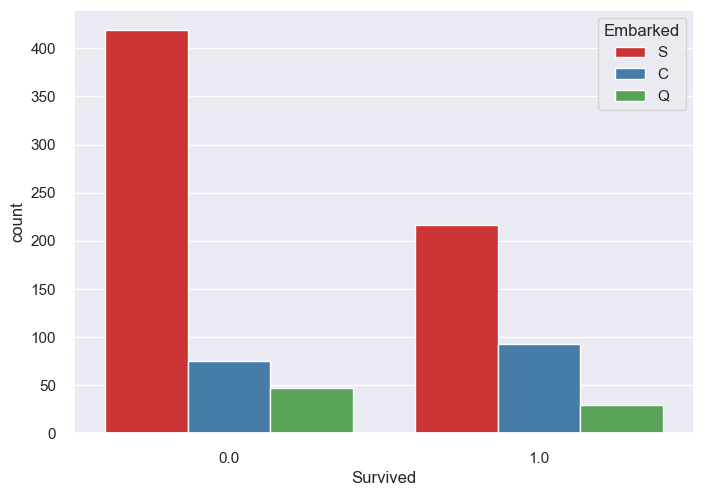

In [27]:
sns.set(style="darkgrid")
sns.countplot( x='Survived', data=train, hue="Embarked", palette="Set1");

In [28]:
train.groupby('Embarked').mean()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Embarked,,,,,,,,
C,445.357143,0.553571,1.886905,0.434524,31.005678,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,0.467532,27.794655,0.428571,0.168831,13.276030
S,450.561321,0.341195,2.345912,0.314465,29.843663,0.476415,0.386792,25.665957


Cependant on remarque que l'espérance de vie est meilleure pour les voyageurs ayant embarqués sur le port de Cherbourg. Après quelques recherches sur internet cette espérance peut être expliquée par un autre facteur : le niveau de vie. En effet, les habitants de Cherbourg ont un meilleur niveau de vie que les habitants des 2 autres ports, cela implique également un investissement plus important dans l'achat de billet et donc sûrement une classe plus importante. Cette hypothèse est également confirmée par le prix du billet que l'on constate à 59,95 vs 13 et 25.

#####  Q2: Est-ce que la survie dépend du sexe ?

In [29]:
train.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
0,455.386364,0.190559,2.388112,31.015567,0.372378,0.220280,24.800851
1,430.660194,0.747573,2.158576,27.795493,0.608414,0.627832,42.822048


Le résultat est sans équivoque. Le cas du titanic est l'exemple parfait du dicton "les femmes et les enfants d'abord". Avec 75% de survie constatée chez les femmes le résultat est sans appel. Cependant, il est possible de vérifier si ces résultats ne peuvnet pas être croisés avec d'autres données.

C:\Users\kcho\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


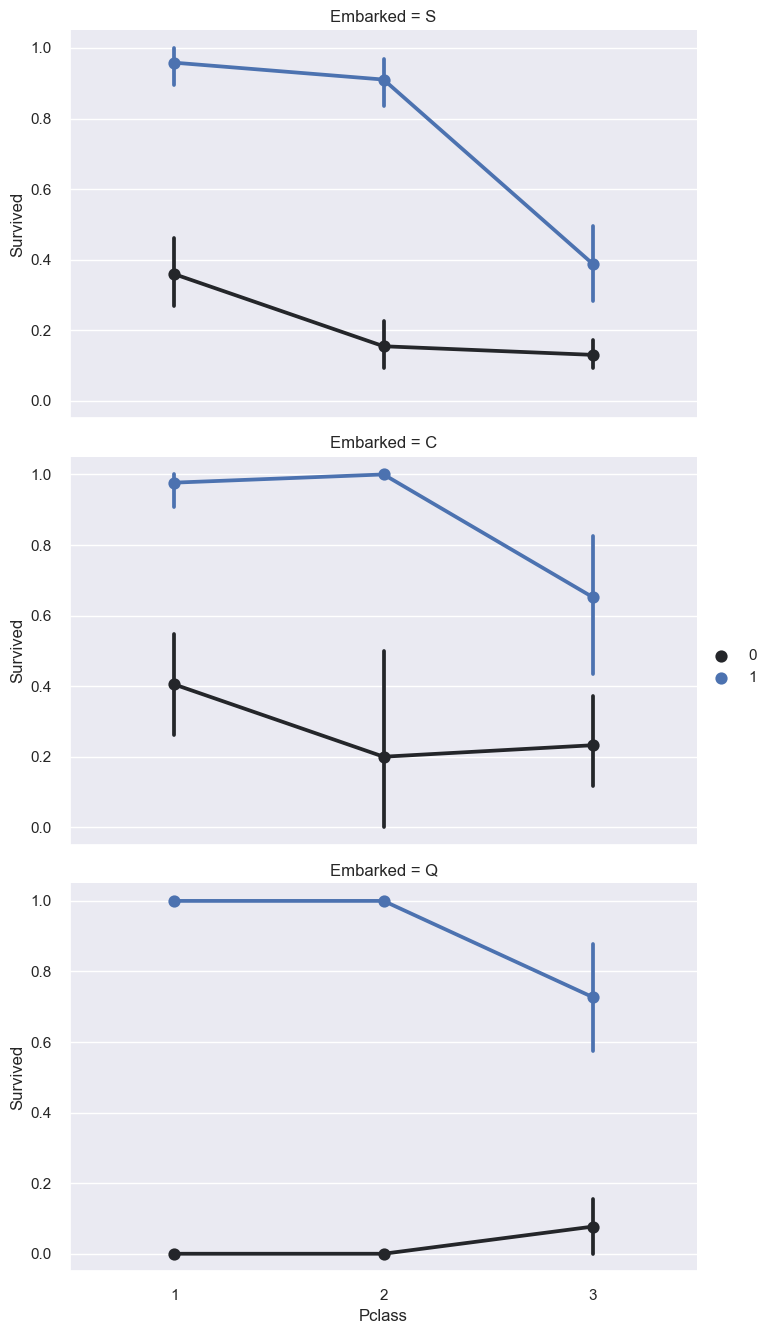

In [30]:
FacetGrid = sns.FacetGrid(train, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
FacetGrid.add_legend();

Il semble y avoir une corrélation entre le port d'embarquement et la survie, selon le sexe des passagers. Les femmes qui ont embarqué au port Q et au port S ont une plus grande chance de survie. C'est le contraire si elles ont embarqué au port C. Les hommes ont une probabilité de survie élevée s'ils ont embarqué au port C, mais une faible probabilité s'ils ont embarqué au port Q ou S. Le niveau de la classe de voyage (Pclass) est également corrélé à la survie. 

In [31]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
0,0.190559
1,0.747573


C:\Users\kcho\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


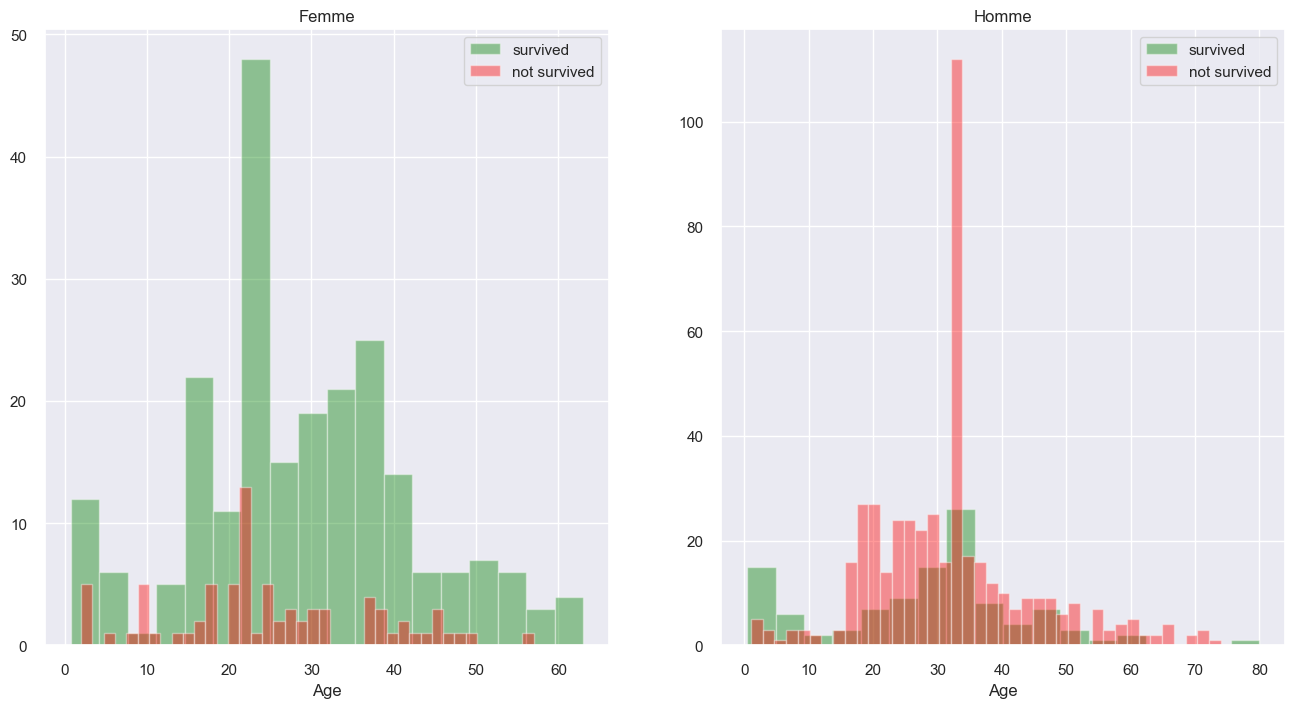

In [32]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
femme = train[train['Sex']==1]
homme = train[train['Sex']==0]
ax = sns.distplot(femme[femme['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(femme[femme['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Femme')
ax = sns.distplot(homme[homme['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(homme[homme['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Homme');

On peut voir que les hommes ont une forte probabilité de survie quand ils ont entre 18 et 30 ans, ce qui est également un peu vrai pour les femmes mais pas complètement. Pour les femmes, les chances de survie sont plus élevées entre 14 et 40 ans. Sachant que les femmes ont généralement une plus forte probabilité de survie.
Pour les hommes, la probabilité de survie est très élevé pour les bébés/nourrissons et pour les jeunes hommes mais c'est également le cas pour les femmes. 

#### Q3 : Est-ce que la classe détermine la probabilité de survie ? 

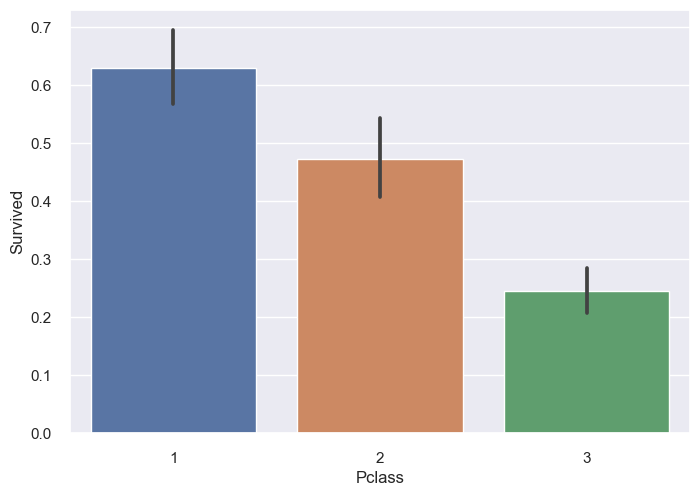

In [33]:
sns.barplot(x='Pclass', y='Survived', data=train);

Pourcentage de la première classe qui ont survécu: 62.91079812206573
Pourcentage de la deuxième classe qui ont survécu 47.28260869565217
Pourcentage de la troisième classe qui ont survécu 24.586776859504134


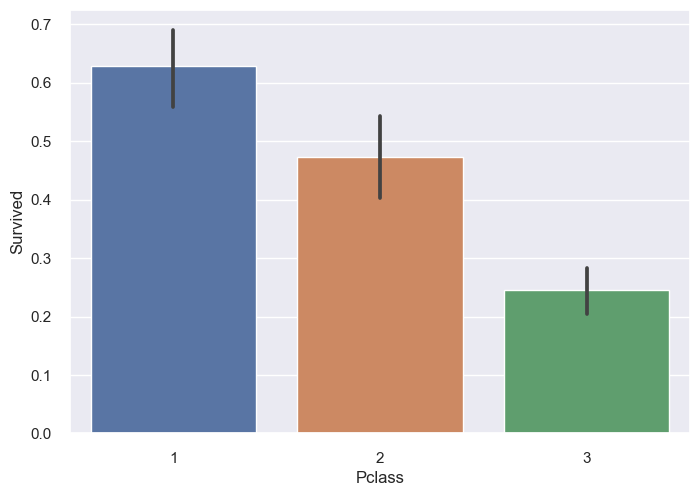

In [34]:
#affiche un diagramme en barres de la survie par Pclass
sns.barplot(x="Pclass", y="Survived", data=train)

#affiche le pourcentage de personnes de la classe P qui ont survécu
print("Pourcentage de la première classe qui ont survécu:", train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100)

print("Pourcentage de la deuxième classe qui ont survécu", train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100)

print("Pourcentage de la troisième classe qui ont survécu", train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100)

C:\Users\kcho\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\kcho\Anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


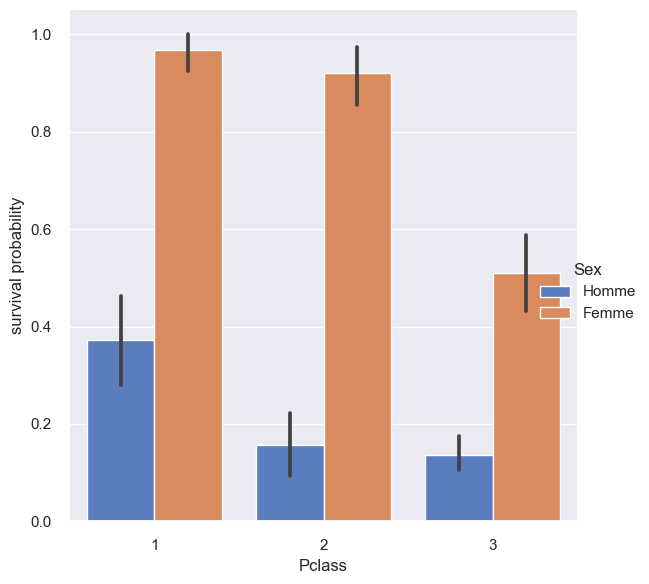

In [35]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
new_labels = ['Homme', 'Femme']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g = g.set_ylabels("survival probability")

C:\Users\kcho\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


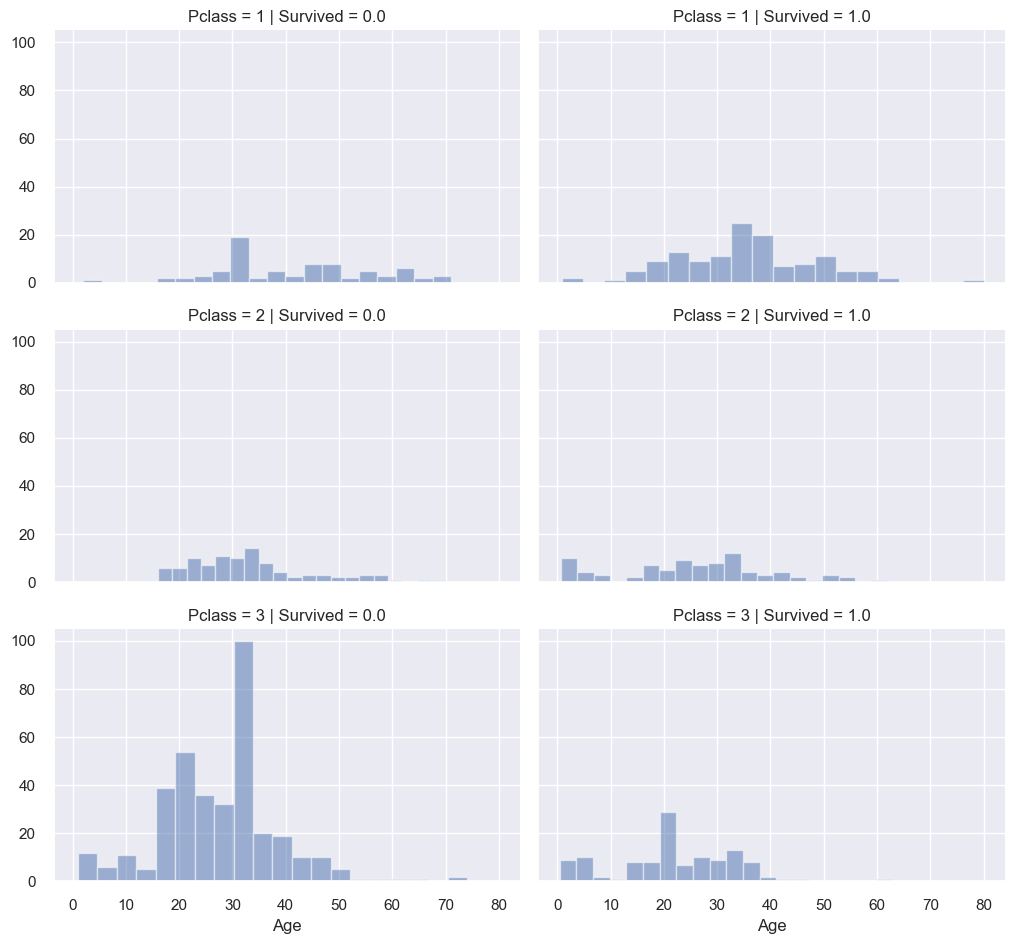

In [36]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=3.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

Ici, nous constatons clairement que la classe (Pclass) a une influence sur les chances de survie d'une personne, en particulier si cette personne est en première classe (1). 
Le graphique ci-dessus confirme notre hypothèse sur la classe 1, mais nous pouvons également constater une forte probabilité qu'une personne en classe 3 ne survivra pas.

#### Q4 : Est-ce que le prix du billet détermine la probabilité de survivre ? 

C:\Users\kcho\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\kcho\Anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


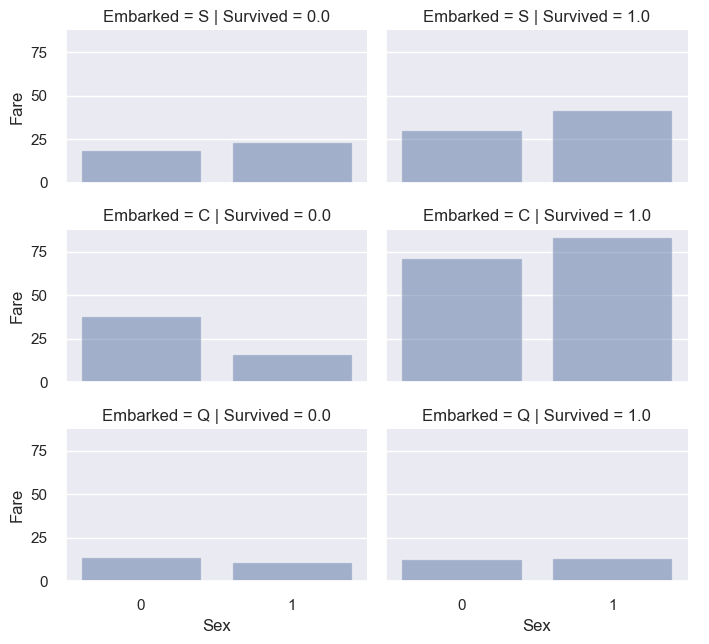

In [37]:
# Créer une grille de facettes pour visualiser la relation entre les features 'Sex', 'Fare', 'Embarked' et 'Survived' dans notre dataset 'train'
grid = sns.FacetGrid(train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

Nous constatons donc que oui, le prix du billet influence bien les chances de survie puisque les tarifs les plus élevés sont ceux qui ont survécu peu importe le port d'embarquement.

#### Q5 - Est-ce que le titre donne une meilleure chance de survie ? 

In [38]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Dr,0.428571
1,Master,0.589744
2,Miss,0.712707
3,Mr,0.161228
4,Mrs,0.795276
5,Rev,0.000000


En effet, on constate que le titre a également son rôle à jouer. Mais davantage car il est lié au sexe ou au niveau de vie de l'individu qui le porte.

#### Q6 : Les passagers qui voyagent seuls ont-ils de meilleures chances de survie ?

SibSp et Parch auraient plus de sens en tant que features combinée, qui montre le nombre total de parents qu'une personne a sur le Titanic. Je vais la créer ci-dessous ainsi qu'une fonctionnalité qui montre si quelqu'un est seul ou non.

In [39]:
data = [train, test]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'voyageur_seul'] = 'Non'
    dataset.loc[dataset['relatives'] == 0, 'voyageur_seul'] = 'Oui'
train['voyageur_seul'].value_counts()

Oui    537
Non    344
Name: voyageur_seul, dtype: int64

In [40]:
train['relatives'].value_counts()

0    537
1    161
2    102
3     29
5     19
4     15
6     12
7      6
Name: relatives, dtype: int64

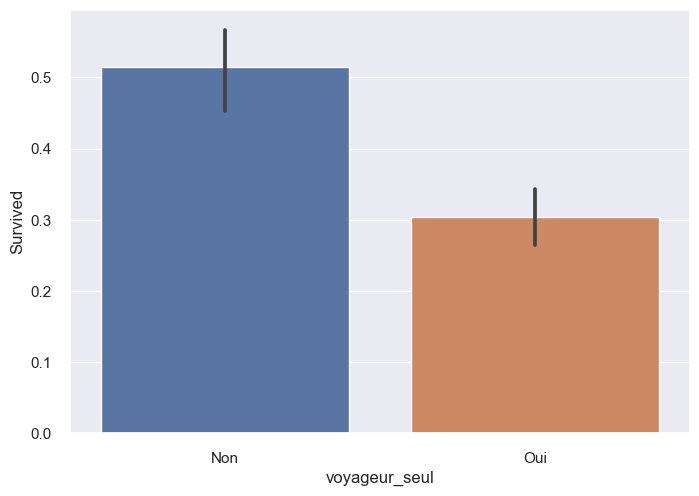

In [41]:
sns.barplot(x='voyageur_seul', y='Survived', data=train);

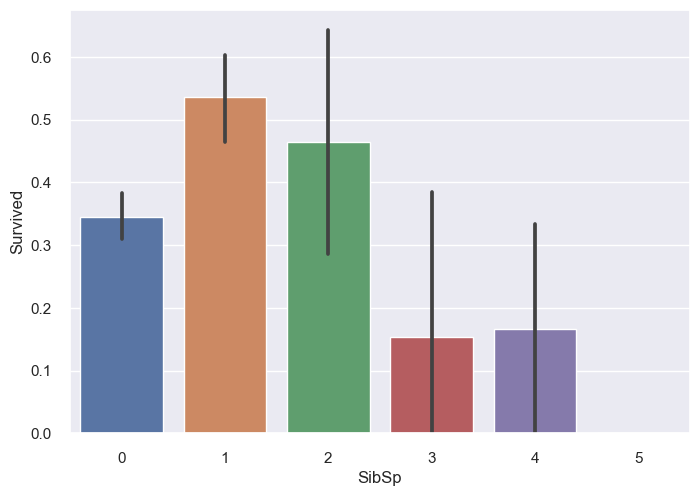

In [42]:
sns.barplot(x='SibSp', y='Survived', data=train);

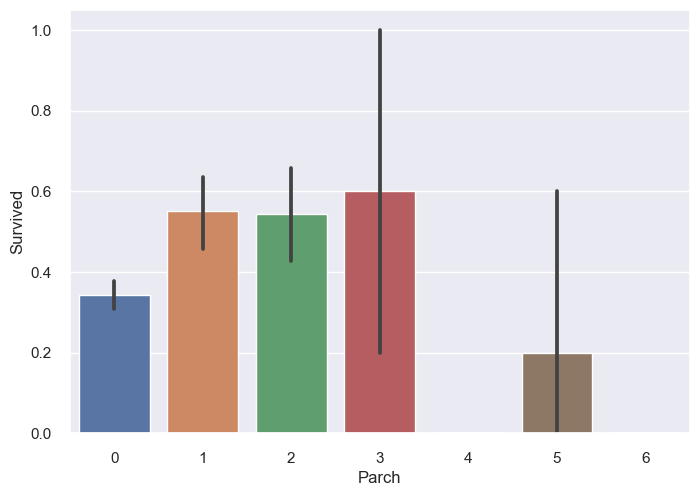

In [43]:
sns.barplot(x='Parch', y='Survived', data=train);

C:\Users\kcho\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\kcho\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


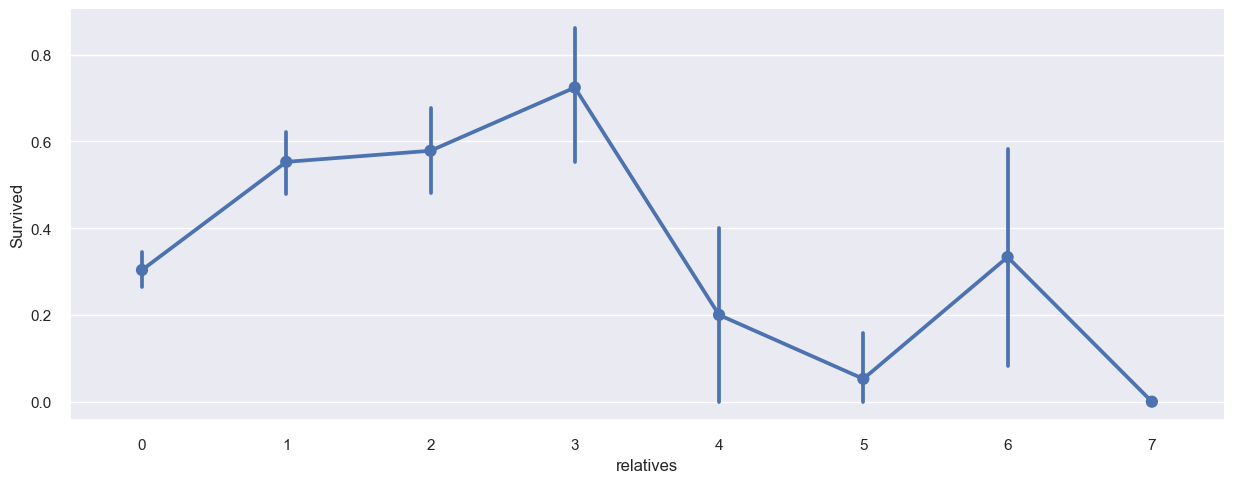

In [44]:
axes = sns.factorplot('relatives','Survived', 
                      data=train, aspect = 2.5, );

On peut constater ici que l'on a une probabilité de survie élevée avec 1 à 3 personnes, mais une probabilité plus faible si on a moins de 1 ou plus de 3 personnes avec nous (sauf pour certains cas avec 6 personnes apparentées). Donc non, il était préférable pour vous de ne pas être seul lorsque le titanic a coulé.

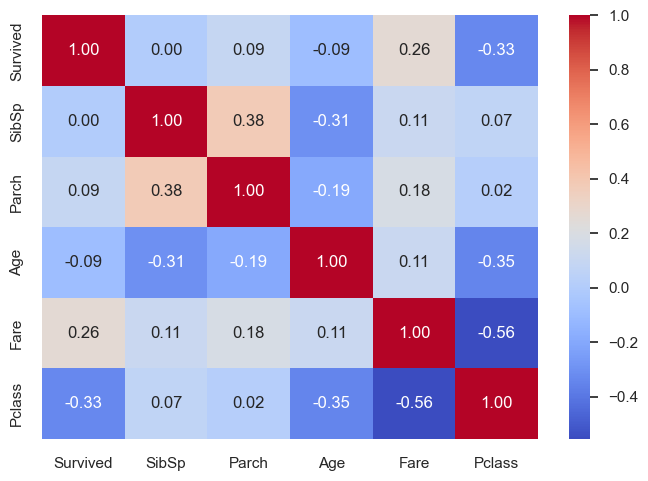

In [45]:
# Matrice de corrélation entre les valeurs numériques (SibSp, Parch, Age, Fare, Title, Pclass) et Survived.
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare","Pclass","voyageur_seul", "Title"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

L'avantage de cette matrice corrélation est qu'il est facile d'interpréter nos résultats et qu'elle permet de récapituler les différents constats que nous avons pu établir au préalable.
A savoir l'impact de : 
- La classe sur l'espérance de survie (une meilleure classe est égale à plus de chance de survie)
- Le prix du billet sur l'espérance de survie (plus le billet est cher plus vous avez de chance de survivre)
- Le sexe et l'âge (les enfants et les femmes ont davantage de chance de survivre)
- Le nombre de personnes avec qui vous voyagez (être seul n'est pas favorable mais être trop nombreux non plus).

## Etape 3 - Data Preparation

### Feature engineering

Maintenant que nous avons réalisé nos analyses nous allons devoir traiter certaines variables afin qu'elles soient interprétables pour notre modèle. C'est notamment le cas pour : 
- Le port d'embarquement qu'il faut convertir en valeur numérique
- Le titre qu'il faut également convertir en valeur numérique

#### Conversion de la variable du port d'embarquement en attribuant des valeurs numériques

In [46]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train, test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [47]:
# Vérification que la modification est bien appliquée pour le dataset de train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,relatives,voyageur_seul
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0,Mr,1,Non
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1,Mrs,1,Non
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0,Miss,0,Oui
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,0,Mrs,1,Non
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0,Mr,0,Oui


In [48]:
# Vérification que la modification est bien appliquée pour le dataset de test
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,relatives,voyageur_seul
881,892,NaN,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,2,Mr,0,Oui
882,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,0,Mrs,1,Non
883,894,NaN,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,2,Mr,0,Oui
884,895,NaN,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,0,Mr,0,Oui
885,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,0,Mrs,2,Non


#### Conversion de la variable du titre en attribuant des valeurs numériques

In [49]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rev": 5, "Dr": 6}
data = [train, test]

for dataset in data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [50]:
# Vérification que la modification est bien appliquée pour le dataset de train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,relatives,voyageur_seul
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0,1,1,Non
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1,3,1,Non
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0,2,0,Oui
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,0,3,1,Non
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0,1,0,Oui


In [51]:
# Vérification que la modification est bien appliquée pour le dataset de test
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,relatives,voyageur_seul
881,892,NaN,3,"Kelly, Mr. James",0,34.5,0,0,7.8292,2,1,0,Oui
882,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,7.0000,0,3,1,Non
883,894,NaN,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,2,1,0,Oui
884,895,NaN,3,"Wirz, Mr. Albert",0,27.0,0,0,8.6625,0,1,0,Oui
885,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,12.2875,0,3,2,Non


### Préparation du modèle de Machine learning

Ces lignes permettent de préparer les données pour un modèle de machine learning en supprimant certaines colonnes, en extrayant la variable cible "Survived" et en remplaçant les valeurs manquantes dans le jeu de données de test.

In [52]:
!pip install catboost

In [53]:
X_train = train.drop(["Survived","Name","voyageur_seul"], axis=1)
Y_train = train["Survived"]
X_test  = test.drop(["PassengerId","Name","voyageur_seul"], axis=1).copy()
X_test["Survived"] = X_test["Survived"].fillna(-1)
X_train.shape, Y_train.shape, X_test.shape

((881, 10), (881,), (418, 10))

Une fois les données préparées il suffit de mettre en place le modèle désiré et de sélectionner le plus pertinent. J'ai décidé de fonctionner en deux étapes:
1) La première méthode ne divise pas les données en jeux de validation et d'entraînement. En effet, dans la première méthode le modèle se base sur l'accuracy (la précision) il est construit en utilisant l'ensemble des données d'entraînement (X_train et Y_train) sans diviser les données en ensembles de validation et d'entraînement distincts. 

2) La deuxième méthode utilise la validation croisée avec StratifiedShuffleSplit, qui divise les données en plusieurs jeux de validation et d'entraînement pour évaluer la performance du modèle de manière plus fiable. Dans cette méthode je vais réaliser une validation croisée sur trois splits différents de mes données d'entraînement

Cela permettra d'avoir 2 points de vue différents sur nos modèles et de croiser les méthodologies.

## Etape 4 - Modeling

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#Pour ignorer les warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

-------------------------


81.27

In [55]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X_train, Y_train)
Y_pred = gbk.predict(X_test)
acc_gbk = round(gbk.score(X_train, Y_train) * 100, 2)
acc_gbk

90.47

In [56]:
# Support Vector Machines
#Pour ignorer les warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

-------------------------


66.17

In [57]:
# KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

80.25

In [58]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

80.7

In [59]:
#Perceptron
perceptron = Perceptron()
knn = KNeighborsClassifier(n_neighbors = 3)
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

66.63

In [60]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

45.18

Avec cette première méthodologie on obtient un modèle à 90,47% avec le 'Gradient Boosting Classifier'. Ce serait donc le modèle le plus performant sans split les données d'entrainement. Cependant, dans cette méthodologie nous avons un risque d'overfitting. Voyons les résultats de notre deuxième méthode.

In [61]:
from sklearn.model_selection import train_test_split

# Supprimer les colonnes inutiles et la colonne "Survived" du jeu de test
X_train = train.drop(["Survived","Name","voyageur_seul"], axis=1)
Y_train = train["Survived"]
X_test  = test.drop(["PassengerId","Name","voyageur_seul"], axis=1).copy()

# Remplacer les valeurs manquantes de la colonne "Survived" par -1
X_test["Survived"] = X_test["Survived"].fillna(-1)

# Diviser les données d'entraînement en jeux d'entraînement et de validation
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.22, random_state = 0)

# Afficher les dimensions des jeux de données
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(X_test.shape)


(687, 10) (687,)
(194, 10) (194,)
(418, 10)


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# Supprimer les colonnes inutiles et la colonne "Survived" du jeu de test
X_train = train.drop(["Survived","Name","voyageur_seul"], axis=1)
Y_train = train["Survived"]
X_test  = test.drop(["PassengerId","Name","voyageur_seul"], axis=1).copy()

# Remplacer les valeurs manquantes de la colonne "Survived" par -1
X_test["Survived"] = X_test["Survived"].fillna(-1)

# Diviser les données d'entraînement en jeux d'entraînement et de validation
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.22, random_state = 0)

# Afficher les dimensions des jeux de données
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(X_test.shape)

# Définir les classifieurs à tester
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    CatBoostClassifier(),
    XGBClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

# Définir le split pour la validation croisée
SSplit = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# Boucle sur les splits et les classifieurs pour obtenir la précision moyenne sur la validation
for train_index, test_index in SSplit.split(X_train, Y_train):
    x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]
    for clf in classifiers:
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        acc = accuracy_score(y_test, y_pred)
        print(clf.__class__.__name__, acc)


(687, 10) (687,)
(194, 10) (194,)
(418, 10)
KNeighborsClassifier 0.6271186440677966
DecisionTreeClassifier 0.7344632768361582
Learning rate set to 0.008868
0:	learn: 0.6876345	total: 161ms	remaining: 2m 40s
1:	learn: 0.6807430	total: 163ms	remaining: 1m 21s
2:	learn: 0.6742153	total: 165ms	remaining: 54.9s
3:	learn: 0.6692265	total: 167ms	remaining: 41.5s
4:	learn: 0.6632676	total: 168ms	remaining: 33.4s
5:	learn: 0.6578032	total: 170ms	remaining: 28.1s
6:	learn: 0.6522321	total: 171ms	remaining: 24.3s
7:	learn: 0.6472208	total: 173ms	remaining: 21.4s
8:	learn: 0.6409945	total: 174ms	remaining: 19.2s
9:	learn: 0.6358152	total: 176ms	remaining: 17.4s
10:	learn: 0.6308981	total: 177ms	remaining: 15.9s
11:	learn: 0.6255336	total: 178ms	remaining: 14.7s
12:	learn: 0.6201626	total: 180ms	remaining: 13.7s
13:	learn: 0.6160845	total: 181ms	remaining: 12.8s
14:	learn: 0.6126223	total: 183ms	remaining: 12s
15:	learn: 0.6072698	total: 184ms	remaining: 11.3s
16:	learn: 0.6043400	total: 185ms	rema

## Etape 5 : Evaluation

L'objectif de cette étape va être d'évaluer notre modèle et de l'optimiser un maximum c'est à dire de choisir les meilleurs valeurs pour nos hyperparamètres (les hyperparamètres sont des paramètres que l'on choisit avant d'entraîner un modèle de machine learning, et qui affectent le processus d'apprentissage et la performance du modèle). Ces paramètres sont essentiels car leur optimisation permet d'obtenir les meilleurs paramètres pour un modèle d'apprentissage automatique et donc d'obtenir des prédictions plus précises et plus fiables.

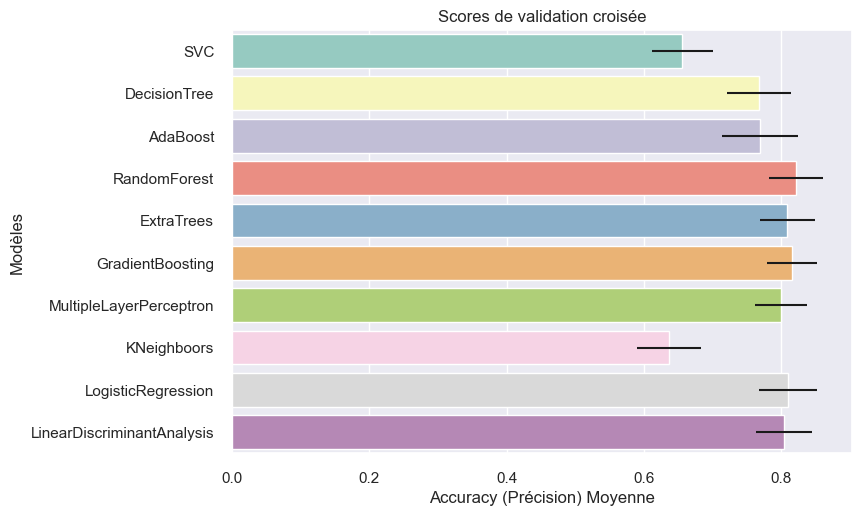

In [63]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Étape de modélisation : Tester différents algorithmes
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    "Accuracy (Précision) Moyenne": cv_means,
    "CrossValerrors": cv_std,
    "Modèles": [
        "SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees",
        "GradientBoosting", "MultipleLayerPerceptron", "KNeighboors",
        "LogisticRegression", "LinearDiscriminantAnalysis"
    ]
})

g = sns.barplot(
    "Accuracy (Précision) Moyenne", "Modèles", data=cv_res, palette="Set3",
    orient="h", **{'xerr': cv_std}
)
g.set_xlabel("Accuracy (Précision) Moyenne")
g = g.set_title("Scores de validation croisée")


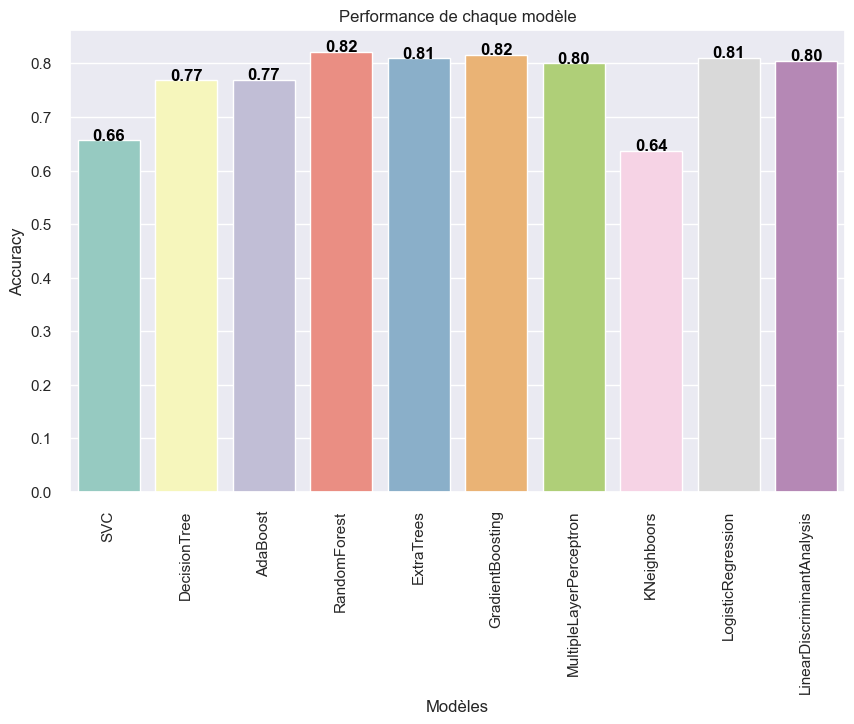

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définir les modèles et leurs noms
classifiers = [SVC(random_state=random_state),
               DecisionTreeClassifier(random_state=random_state),
               AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1),
               RandomForestClassifier(random_state=random_state),
               ExtraTreesClassifier(random_state=random_state),
               GradientBoostingClassifier(random_state=random_state),
               MLPClassifier(random_state=random_state),
               KNeighborsClassifier(),
               LogisticRegression(random_state=random_state),
               LinearDiscriminantAnalysis()]

model_names = ["SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees",
               "GradientBoosting", "MultipleLayerPerceptron", "KNeighboors",
               "LogisticRegression", "LinearDiscriminantAnalysis"]

# Calculer la performance de chaque modèle
performance = []
for classifier in classifiers:
    cv_results = cross_val_score(classifier, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=4)
    performance.append(cv_results.mean())

# Créer un graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=performance, palette="Set3")
plt.xticks(rotation=90)
plt.xlabel("Modèles")
plt.ylabel("Accuracy")
plt.title("Performance de chaque modèle")

# Ajouter les légendes correspondant à la valeur de chaque modèle
for i, v in enumerate(performance):
    plt.text(i, v, "{:.2f}".format(v), color='black', ha='center', fontweight='bold')

plt.show()


L'avantage de cette deuxième option réside dans sa méthode de calcul. En effet, ici pour chaque split une précision sera calculée et la précision du modèle correspondra à la moyenne des précisions du modèle sur chacune des données splitées. Cela permet de nous rassurer sur la performance du modèle, de limiter l'overfitting et d'annoncer que la random forest semble être le modèle le plus précis avec 84% de précision. Nous pouvons toutefois l'améliorer en modifiant ses hyperparamètres. 

#### Identification des features les plus importantes dans notre modèle

Je me suis permis d'ajouter ce tableau qui contient l'importance de chaque feature dans le modèle de forêt aléatoire (random_forest) pour voir le poids de chaque feature dans le modèle.

In [65]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Entraîner le modèle sur les données d'entraînement
random_forest.fit(X_train, Y_train)
importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(random_forest.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending= False).set_index('feature')

importances.head(15)

,importance
feature,
Sex,0.261
Title,0.258
Fare,0.136
Pclass,0.103
relatives,0.068
Age,0.065
PassengerId,0.049
SibSp,0.031
Embarked,0.015


#### Identification des meilleurs hyperparamètres

In [66]:
from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à tester pour la Random Forest
rf_param_grid = {
    'n_estimators': [100, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Instancier la Random Forest
rf = RandomForestClassifier()

# Recherche par grille pour optimiser les hyperparamètres de la Random Forest
rf_grid_search = GridSearchCV(estimator = rf, param_grid = rf_param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Entraîner la Random Forest avec les hyperparamètres optimisés
rf_grid_search.fit(x_train, y_train)

# Afficher les hyperparamètres optimisés
print("Meilleurs hyperparamètres pour la Random Forest: ", rf_grid_search.best_params_)

# Afficher la précision de la Random Forest avec les hyperparamètres optimisés
y_pred = rf_grid_search.predict(x_val)
acc = accuracy_score(y_val, y_pred)
print("Précision de la Random Forest avec les hyperparamètres optimisés: ", acc)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Meilleurs hyperparamètres pour la Random Forest:  {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Précision de la Random Forest avec les hyperparamètres optimisés:  0.9175257731958762


Le modèle le plus performant que nous pouvons obtenir se base sur la Random Forest est à une précision de 91,75%. Les meilleurs hyperparamètres sont : une max_depth de 30, un min_samples_leaf de 2, un min_samples_split de 2 et un n_estimators de 100. Voilà le modèle le plus performant que j'ai pu obtenir.

#### Evaluation approfondie du modèle

Maintenant que la performance de prédiction de notre modèle est optimisée nous allons tenter de déterminer de mesurer sa performance globale à travers 3 indicateurs : 
- Le Score F1 : nous permettra de déterminer sa performance si les classes cibles sont déséquilibrées (grande différence dans le nombre d'échantillons entre les classes positives et négatives)
- La matrice de confusion : elle fournit des informations détaillées sur les erreurs de classification commises par le modèle, notamment les faux positifs, les faux négatifs, les vrais positifs et les vrais négatifs. Elle nous permet ainsi de comprendre où le modèle peut ne pas être performant et d'identifier les types d'erreurs spécifiques qu'il commet.
- La courbe ROC (Receiver Operating Characteristic) : La courbe ROC qaunt à elle évalue la capacité d'un modèle à discriminer entre les classes positives et négatives en fonction de différents seuils de classification. Elle fournit des informations sur la sensibilité (rappel) et la spécificité (taux de vrais négatifs) du modèle à différents niveaux de seuil de classification. 

#### Score F1 de la Random Forest avec les hyperparamètres optimisés

Rapide rappel sur ce qu'est le score F1. Le score F1 permet d'évaluer la capacité d'un modèle de classification à prédire efficacement les individus positifs. Il est calculé en combinant la précision (ou le taux de vrais positifs) et le rappel (ou le taux de vrais positifs prédits) d'un modèle en une seule mesure.

In [67]:
from sklearn.metrics import f1_score

# Prédire les valeurs cibles pour le jeu de validation
y_pred = rf_grid_search.predict(x_val)

# Calculer le score F1 avec les hyperparamètres optimisés pour la Random Forest
f1 = f1_score(y_val, y_pred, average='weighted')

print("Score F1 de la Random Forest avec les hyperparamètres optimisés: ", f1)


Score F1 de la Random Forest avec les hyperparamètres optimisés:  0.9168535050729398


#### Comment interpréter ce score ?

Le score F1 varie entre 0 et 1, où 1 est le meilleur score possible. Un score à 1 correspond à une classification parfaite (ce qui est bien souvent inatteignable dans les faits). Un score F1 élevé signifie que le modèle a à la fois une haute précision et un haut rappel, ce qui indique qu'il est capable de bien classifier les exemples positifs tout en minimisant les erreurs de classification.

Ici notre score est de 0.92 ce qui correspond à un très bon score (si on prend en compte la taille de l'échantillon, la distribution...). Notre modèle va donc classer correctement la majorité des exemples positifs tout en minimisant les erreurs de classification avec un très bon équilibre entre précision (peu d'erreurs de faux positifs) et rappel (bonne prédiction des vrais positifs).

#### Matrice de confusion 

Matrice de confusion : 
[[113,   5],
 [ 11,  65]]


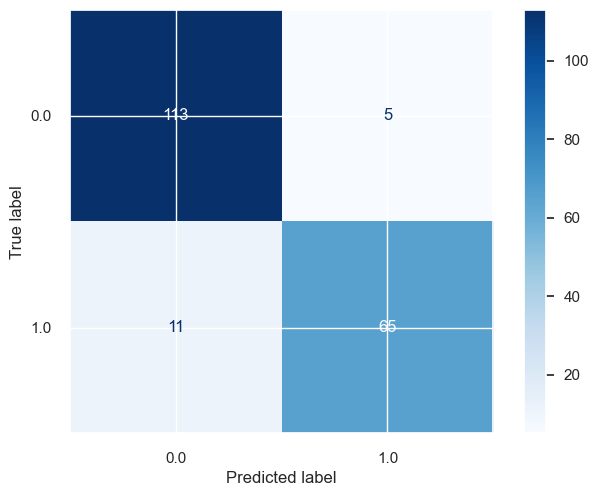

In [68]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# Utiliser le modèle optimisé pour prédire les classes sur le jeu de validation
y_pred = rf_grid_search.predict(x_val)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_val, y_pred)

# Afficher la matrice de confusion sous forme de matrice
print("Matrice de confusion : ")
print(np.array2string(conf_matrix, separator=', '))

# Afficher la matrice de confusion sous forme graphique
plot_confusion_matrix(rf_grid_search, x_val, y_val, cmap=plt.cm.Blues)
plt.show()

#### Qu'est-ce qu'une matrice de confusion ?

Je vais me permettre de citer Wikipedia car la définition proposée par leur soin propose une vision très simpliste mais pourtant fidèle de ce qu'elle permet de démontrer : "la matrice de confusion est une matrice qui mesure la qualité d'un système de classification". En somme, elle compare les données réelles pour une variable cible à celles prédites par un modèle.
Cependant, il a également fait 14 erreurs en prédisant une survie alors qu'il n'y en avait pas et 8 erreurs en prédisant l'absence de survie alors qu'il y en avait une.
En résumé voici ce que l'on peut interpréter de la matrice de confusion : 
- 113 Vrais négatifs : Représente le nombre de passagers du Titanic qui sont réellement prédits comme n'ayant pas survécu et qui ont été correctement prédits comme tels par le modèle.
- 5 Faux positifs : Représente le nombre de passagers du Titanic qui sont réellement n'ayant pas survécu mais qui ont été incorrectement prédits comme ayant survécu par le modèle.
- 11 Faux négatifs : Représente le nombre de passagers du Titanic qui sont réellement n'ayant pas survécu mais qui ont été incorrectement prédits comme ayant survécu par le modèle.
- 65 Vrais positifs :  Représente le nombre de passagers du Titanic qui sont réellement prédits comme ayant survécu et qui ont été correctement prédits par le modèle

In [74]:
from sklearn.metrics import confusion_matrix

# Matrice de confusion
conf_matrix = np.array([[113, 5], [11, 65]])

# Calcul du nombre total d'échantillons
total_samples = np.sum(conf_matrix)

# Taux d'erreur
error_rate = (conf_matrix[0,1] + conf_matrix[1,0]) / total_samples

# Accuracy
accuracy = (conf_matrix[0,0] + conf_matrix[1,1]) / total_samples

# Précision
precision = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[0,1])

# Rappel (sensibilité, taux de vrais positifs)
recall = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[1,0])

# Specificité (taux de vrais négatifs)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])

# False Positive Rate (taux de faux positifs)
fpr = conf_matrix[0,1] / (conf_matrix[0,0] + conf_matrix[0,1])

# Score F1
f1_score = 2 * (precision * recall) / (precision + recall)

# Affichage des résultats
print("Taux d'erreur : ", error_rate)
print("Accuracy : ", accuracy)
print("Précision : ", precision)
print("Rappel : ", recall)
print("Specificité : ", specificity)
print("False Positive Rate : ", fpr)
print("Score F1 : ", f1_score)


Taux d'erreur :  0.08247422680412371
Accuracy :  0.9175257731958762
Précision :  0.9285714285714286
Rappel :  0.8552631578947368
Specificité :  0.9576271186440678
False Positive Rate :  0.0423728813559322
Score F1 :  0.8904109589041096


Certaines métriques peuvent être calculées à partir du tableau de contingence. Voici leurs interprétations : 
- Le taux d'erreur indique que seulement environ 8% des échantillons sont mal classés
- L'accuracy indique que près de 92% des échantillons sont correctement classés
- La précision indique que près de 93% des échantillons prédits comme positifs sont réellement positifs
- Le rappel indique que près de 86% des échantillons réellement positifs sont correctement prédits comme positifs, ce qui est généralement considéré comme bon.
- La spécificité indique que près de 96% des échantillons réellement négatifs sont correctement prédits comme négatifs
- Le taux de faux positif indique que seulement environ 4% des échantillons réellement négatifs sont incorrectement prédits comme positifs
- Et pour finir, le score F1 (mesure combinée de la précision et du rappel) de 0,89est également bon !

Cela peut nous conforter lorsqu'il s'agit d'affirmer que notre modèle a une bonne performance en termes d'accuracy, de précision, de rappel, de spécificité, de FPR et de score F1.

#### Analyse de la performance à travers la courbe ROC

Nous allons utiliser la courbe ROC pour évaluer la performance de notre modèle de classification binaire. Elle va nous permettre de déterminer la capacité du modèle à "discriminer" entre les classes positives et négatives et ce à différents seuils de classification. Nous aurons donc une vue globale de sa performance sur tous les seuils et donc nous pourrons même identifier le seuil optimal pour notre classification. 

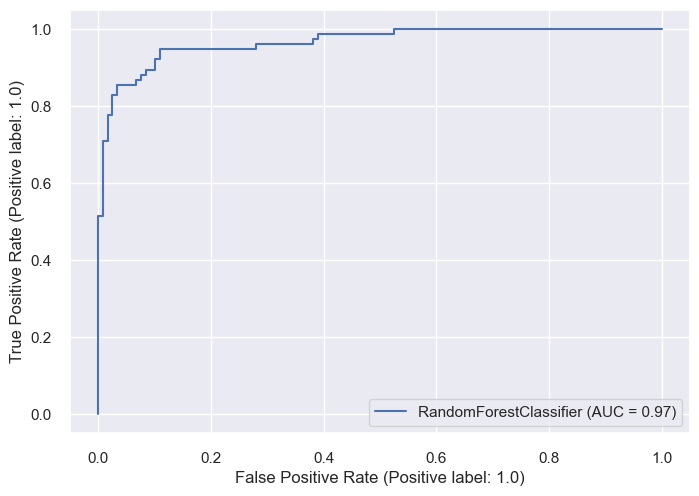

In [73]:
from sklearn.metrics import plot_roc_curve

# Obtenir le meilleur modèle après la recherche par grille
best_rf = rf_grid_search.best_estimator_

# Afficher la courbe ROC pour le meilleur modèle
plot_roc_curve(best_rf, x_val, y_val)
plt.show()


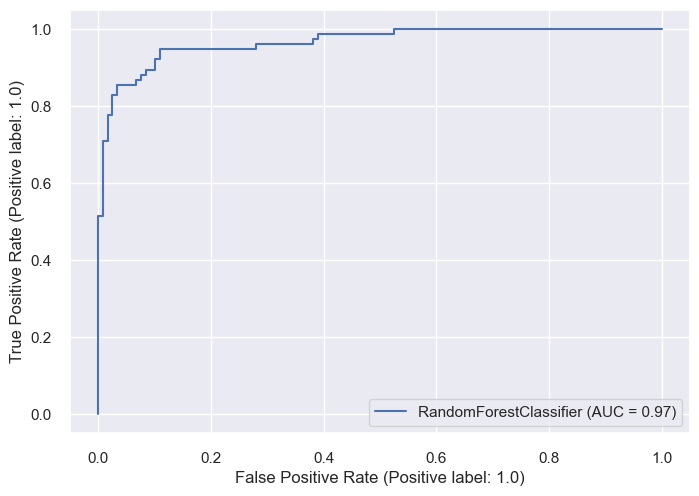

Faux positifs :  [0.         0.         0.         0.00847458 0.00847458 0.01694915
 0.01694915 0.02542373 0.02542373 0.03389831 0.03389831 0.06779661
 0.06779661 0.07627119 0.07627119 0.08474576 0.08474576 0.10169492
 0.10169492 0.11016949 0.11016949 0.27966102 0.27966102 0.38135593
 0.38135593 0.38983051 0.38983051 0.52542373 0.52542373 0.92372881
 0.94067797 1.        ]
Vrais positifs :  [0.         0.01315789 0.51315789 0.51315789 0.71052632 0.71052632
 0.77631579 0.77631579 0.82894737 0.82894737 0.85526316 0.85526316
 0.86842105 0.86842105 0.88157895 0.88157895 0.89473684 0.89473684
 0.92105263 0.92105263 0.94736842 0.94736842 0.96052632 0.96052632
 0.97368421 0.97368421 0.98684211 0.98684211 1.         1.
 1.         1.        ]


In [71]:
# Obtenir le meilleur modèle après la recherche par grille
best_rf = rf_grid_search.best_estimator_

# Afficher la courbe ROC pour le meilleur modèle
plot_roc_curve(best_rf, x_val, y_val)
plt.show()

# Obtenir les valeurs des faux positifs, des vrais positifs et des seuils
fpr, tpr, thresholds = roc_curve(y_val, best_rf.predict_proba(x_val)[:,1])

# Afficher les valeurs des faux positifs et des vrais positifs
print("Faux positifs : ", fpr)
print("Vrais positifs : ", tpr)


Un AUC (Area Under Curve) de 0,97 est un excellent score et indique que le modèle est très performant pour la classification binaire. Cela veut dire que le modèle a une excellente capacité de discrimination entre les classes positives (par exemple, les passagers qui ont survécu) et les classes négatives (par exemple, les passagers qui n'ont pas survécu) avec une très faible probabilité d'erreur de classification.

Pour finir, il est donc possible de conclure que le modèle de Random Forest étudié est fiable et a tendance à avoir une très bonne prédiction pour identifier les passagers décédés ainsi que la prédiction des passagers ayant survécu.

In [84]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': rf_grid_search})
output.to_csv('kevin_c.csv', index=False)
print("Votre demande a été enregistrée avec succès !")

Votre demande a été enregistrée avec succès !
